# Phase 4 Project

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
classification_report, accuracy_score, precision_score, plot_confusion_matrix
from wordcloud import WordCloud

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sw = stopwords.words('english')

In [4]:
df = pd.read_csv('/Users/meaghanross/Documents/Flatiron/Phase4/NLP_project/data/tweet_product_company.csv', encoding='latin1' )

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df.shape

(9093, 3)

In [7]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To do

2) Fill nas for the brand
3) Label encode the target 
6) dropping 'I can't tell'
7) drop duplicates


In [9]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']

In [10]:
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

In [11]:
df['text']=df['tweet_text']

In [12]:
df.drop('tweet_text',axis=1, inplace=True)

In [13]:
df['length']= df['text'].str.len()

In [14]:
df.shape

(9093, 4)

__Drop Duplicates__

In [15]:
df.duplicated().sum()

22

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.shape

(9071, 4)

In [18]:
df.dropna(subset=['text'], inplace=True)

In [19]:
df.target.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: target, dtype: int64

In [20]:
df.text.isna().sum()

0

In [21]:
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.stem import PorterStemmer

In [22]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [23]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    tweet_token = TweetTokenizer()
    doc = tweet_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    stemmer = PorterStemmer() 
    doc = [stemmer.stem(word) for word in doc]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [24]:
df['tokenized'] = df['text'].apply(doc_preparer)

In [25]:
df.head()

,emotion_in_tweet_is_directed_at,target,text,length,tokenized
0,iPhone,Negative emotion,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,127.0,. @wesley83 3g iphon . 3 hr tweet #rise_austin...
1,iPad or iPhone App,Positive emotion,@jessedee Know about @fludapp ? Awesome iPad/i...,139.0,@jessede know @fludapp ? awesom ipad / iphon a...
2,iPad,Positive emotion,@swonderlin Can not wait for #iPad 2 also. The...,79.0,@swonderlin wait #ipad 2 also . sale #sxsw .
3,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as cra...,82.0,@sxsw hope year' festiv crashi year' iphon app...
4,Google,Positive emotion,@sxtxstate great stuff on Fri #SXSW: Marissa M...,131.0,@sxtxstate great stuff fri #sxsw : marissa may...


__Train-Test Split__

In [26]:
X = df.drop(['target','emotion_in_tweet_is_directed_at', 'text'],axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=42,
                                                    stratify=y)

In [27]:
X_train.shape

(6802, 2)

__Data Cleaning__

For cleaning we want to drop 'I can't tell' after merging `X_train` with `y_train` and `X_test` with `y_test` to and Label Encode the target to numerical data.

In [28]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [29]:
y_train.value_counts()

No emotion toward brand or product    4031
Positive emotion                      2227
Negative emotion                       427
I can't tell                           117
Name: target, dtype: int64

In [30]:
df_train.head()

,length,tokenized,target
2769,126.0,want one ! ! rumor : appl open temporari store...,Positive emotion
2787,48.0,#aapl alreadi big winner #sxsw { link } #in,No emotion toward brand or product
7021,64.0,@mention google' disavow plan launch #sxsw .,No emotion toward brand or product
4882,94.0,anyon go buy new ipad donat #japan #tsunami vi...,I can't tell
715,123.0,{ link } part present #sxsw good thing crash i...,Positive emotion


In [31]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df

In [32]:
def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df

In [33]:
cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [34]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [35]:
df_test_clean.head()

,length,tokenized,target
5039,132.0,rt @mention : aron pilhof new york time endors...,0
643,70.0,"ok nerd , total bateman . want sign ipad 2 ? #...",0
4451,124.0,podcast social busi summit 2011 austin { link ...,2
177,56.0,#win pictur #android #googl #sxsw { link },2
4980,66.0,team android sxsw  ûò full parti detail revea...,2


In [36]:
df_train_clean.target.value_counts()

0    4031
2    2227
1     427
Name: target, dtype: int64

## Model Iterations

In [37]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())


### FSM

In [38]:
sw = stopwords.words('english')

In [39]:
fsm_pipe = Pipeline([('cv', CountVectorizer(stop_words=sw)),
                     ('mnb', MultinomialNB())
])

In [40]:
fsm_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [41]:
print_cv_scores(fsm_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.81750187 0.80890052 0.81993269 0.81899776 0.81993269]
Training Accuracy 0.8170531039640988
##############
[0.66417352 0.66043381 0.66641735 0.68885565 0.63350785]
Cross_Val Accuracy 0.6626776364996261
##############
Training Macro Precision: 0.8151284668686385
Cross_Val Macro Precision: 0.6236818689355725
##############
Training Macro Recall: 0.6841889284979017
Cross_Val Macro Recall: 0.4829897113475604
##############
Training Macro F1: 0.7247304398946743
Cross_Val Macro F1: 0.502312244302612


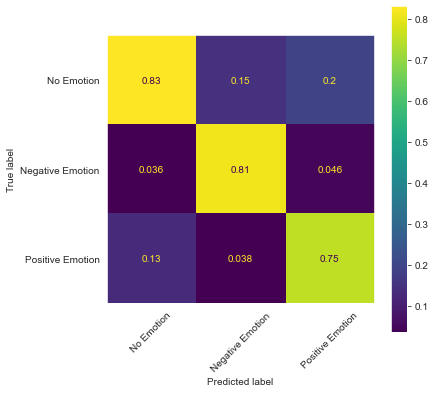

In [158]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

y_true = df_train_clean['target']
y_pred = fsm_pipe.predict(df_train_clean['tokenized'])

cm = confusion_matrix(y_true, y_pred, normalize = 'pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
ax.grid(False)
disp.ax_.set_xticklabels(display_labels,rotation=45);


In [44]:
bayes_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw,
                                                 max_features=None)),
                       ('mnb', MultinomialNB())
])

In [45]:
bayes_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [46]:
print_cv_scores(bayes_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.7460733  0.74700823 0.74308153 0.73934181 0.75448766]
Training Accuracy 0.7459985041136874
##############
[0.6499626  0.64921466 0.66492147 0.65445026 0.64098728]
Cross_Val Accuracy 0.6519072550486164
##############
Training Macro Precision: 0.8745680906330675
Cross_Val Macro Precision: 0.7493263672200777
##############
Training Macro Recall: 0.4855068247072231
Cross_Val Macro Recall: 0.3983479901848868
##############
Training Macro F1: 0.4902655231955134
Cross_Val Macro F1: 0.38008587682970113


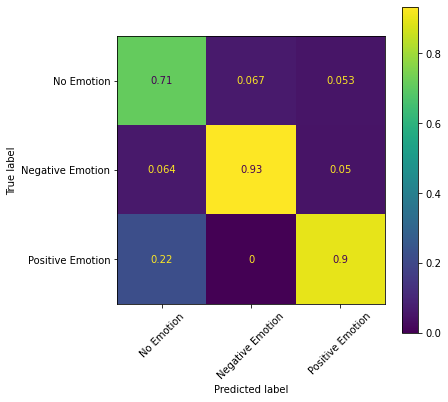

In [47]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

y_true = df_train_clean['target']
y_pred = bayes_pipe.predict(df_train_clean['tokenized'])

cm = confusion_matrix(y_true, y_pred, normalize = 'pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
disp.ax_.set_xticklabels(display_labels,rotation=45);


In [48]:
len(bayes_pipe[0].vocabulary_)

6614

## Final Model Evaluation

In [156]:
bayes_pipe.score(df_test_clean['tokenized'], df_test_clean['target'])

0.664423508299686

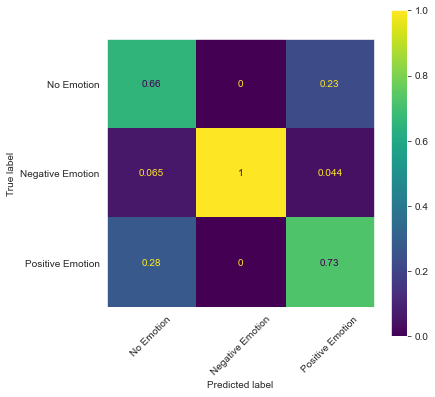

In [159]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

y_true = df_test_clean['target']
y_pred = bayes_pipe.predict(df_test_clean['tokenized'])

cm = confusion_matrix(y_true, y_pred, normalize = 'pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
ax.grid(False)
disp.ax_.set_xticklabels(display_labels,rotation=45);

In [161]:
precision_score(y_true, y_pred, average='macro')

0.7937817162766038

### Bayes with length

In [49]:
df_train_clean['tokenized']

2769    want one ! ! rumor : appl open temporari store...
2787          #aapl alreadi big winner #sxsw { link } #in
7021         @mention google' disavow plan launch #sxsw .
715     { link } part present #sxsw good thing crash i...
4072    #ipad2 sell , 70 % go new buyer - wow ! { link...
                              ...                        
426     mobil definit hot topic year . everi session s...
1548    @mention @mention @mention googl circl , inde ...
769     googl launch major new social network call cir...
4425    post googl / bing q / @mention @mention @menti...
4102               gsdm googl parti hook ! #sxsw { link }
Name: tokenized, Length: 6685, dtype: object

In [50]:
tfidf = TfidfVectorizer(stop_words=sw, max_features=None)

train_vectorized = tfidf.fit_transform(df_train_clean['tokenized']).toarray()

train_vectorized_df = pd.DataFrame(train_vectorized,
                                   columns=tfidf.get_feature_names(), 
                                   index=df_train_clean.index)

In [51]:
train_vectorized_df['length']=df_train_clean['length']
train_vectorized_df['length']

2769    126.0
2787     48.0
7021     64.0
715     123.0
4072     82.0
        ...  
426     139.0
1548    127.0
769     107.0
4425     96.0
4102     48.0
Name: length, Length: 6685, dtype: float64

In [52]:
train_vectorized_df.head()

,00,000,01,02,03,0310appl,06,08,10,100,...,ûïwin,ûò,ûòand,ûó,ûócan,ûójust,ûólot,ûómi,ûóthe,ü_
2769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
mnb = MultinomialNB()
mnb.fit(train_vectorized_df, 
        df_train_clean['target'])


MultinomialNB()

In [54]:
cross_validate(mnb, 
               train_vectorized_df, 
               df_train_clean['target'], 
               return_train_score=True,
               scoring = 'precision_macro')


{'fit_time': array([0.19201994, 0.15828514, 0.14195919, 0.14024782, 0.1447382 ]),
 'score_time': array([0.04059076, 0.0300529 , 0.03027987, 0.03202033, 0.03015804]),
 'test_score': array([0.44110179, 0.47894855, 0.52607671, 0.49019608, 0.47999051]),
 'train_score': array([0.53328426, 0.5309351 , 0.53035842, 0.52634926, 0.52246497])}

In [55]:
scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
results = cross_validate(mnb, 
                         train_vectorized_df, 
                         df_train_clean['target'],
                         return_train_score=True, 
                         scoring=scoring)
    
print(results['train_accuracy'])
print('Training Accuracy', results['train_accuracy'].mean())
print('##############')
print(results['test_accuracy'])
print('Cross_Val Accuracy', results['test_accuracy'].mean())
print('##############')
print('Training Macro Precision:', results['train_precision_macro'].mean())
print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
print('##############')
print('Training Macro Recall:', results['train_recall_macro'].mean())
print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
print('##############')
print('Training Macro F1:', results['train_f1_macro'].mean())
print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

[0.64154824 0.63967838 0.63855647 0.6368736  0.64528796]
Training Accuracy 0.6403889304412865
##############
[0.61555722 0.62228871 0.62228871 0.61854899 0.6170531 ]
Cross_Val Accuracy 0.619147344801795
##############
Training Macro Precision: 0.5286784012301611
Cross_Val Macro Precision: 0.48326272791120173
##############
Training Macro Recall: 0.37125526896703026
Cross_Val Macro Recall: 0.3511708865357469
##############
Training Macro F1: 0.3254879360138335
Cross_Val Macro F1: 0.2901195406935698


In [56]:
df_train_clean.target.value_counts()

0    4031
2    2227
1     427
Name: target, dtype: int64

In [57]:
strategy = {0:4031, 1:427, 2:2227}
bayes_smote_pipe = imbpipe([
                            ('tfidf', TfidfVectorizer(stop_words=sw)),
                            ('smote', SMOTE(random_state=42,
                                            sampling_strategy=strategy)),
                            ('mnb', MultinomialNB())
])
bayes_smote_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('smote',
                 SMOTE(random_state=42,
                       sampling_strategy={0: 4031, 1: 427, 2: 2227})),
                ('mnb', MultinomialNB())])

In [58]:
print_cv_scores(bayes_smote_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.76477188 0.76589379 0.75841436 0.75766642 0.76757666]
Training Accuracy 0.7628646222887061
##############
[0.65669409 0.64921466 0.66791324 0.66940912 0.644727  ]
Cross_Val Accuracy 0.6575916230366492
##############
Training Macro Precision: 0.862916100201965
Cross_Val Macro Precision: 0.7429717952456116
##############
Training Macro Recall: 0.5122584600735886
Cross_Val Macro Recall: 0.4095633806577676
##############
Training Macro F1: 0.5265164539330164
Cross_Val Macro F1: 0.3982558212744151


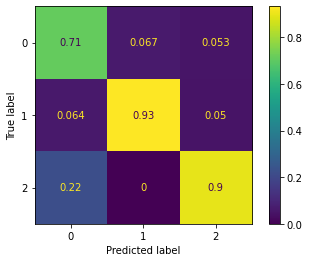

In [59]:
plot_confusion_matrix(bayes_smote_pipe, 
                      df_train_clean['tokenized'], 
                      df_train_clean['target'],
                      normalize='pred');

In [60]:
xgb_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw)),
                          ('sm', SMOTE(random_state=42)),
                          ('xgb', XGBClassifier(random_state=42,
                                                max_depth = 6,
                                                n_jobs = -1))])

In [61]:
# xgb_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

In [62]:
# print_cv_scores(xgb_pipe, df_train_clean['tokenized'], df_train_clean['target'])

In [63]:
# plot_confusion_matrix(xgb_pipe, 
#                       df_train_clean['tokenized'], 
#                       df_train_clean['target'], 
#                       normalize='pred');

In [64]:
# xgb_gs_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw, 
#                                                        token_pattern=r'(?u)\b[A-Za-z]+\b')),
#                               ('sm', SMOTE(random_state=42)),
#                               ('xgb', XGBClassifier(random_state=42,
#                                                    n_jobs = -1,
#                                                    max_depth=6,
#                                                    tree_method= 'hist'))])

In [65]:
# param_grid = [{'tfidf__max_features': [5000, None],
#                'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]}]

# gs_pipe = GridSearchCV(estimator=xgb_gs_pipe, 
#                        param_grid=param_grid, 
#                        verbose=2, 
#                        scoring='precision_macro')

In [66]:
# gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

In [67]:
# pd.DataFrame(gs_pipe.cv_results_)

In [68]:
# gs_pipe.best_score_

In [69]:
# idf_values = dict(zip(gs_pipe.best_estimator_[0].get_feature_names(), gs_pipe.best_estimator_[0].idf_))
# [print(v) for i, v in enumerate(idf_values.items()) if i < 5]

In [70]:
# max(gs_pipe.best_estimator_[0].idf_)

In [71]:
# rf_SVD_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
#                           ('svd', TruncatedSVD(n_components=30,
#                                                random_state=42)),
#                           ('rf', RandomForestClassifier(max_depth=12,
#                                                         class_weight='balanced',
#                                                         random_state=42))
# ])

In [72]:
# print_cv_scores(rf_SVD_pipe, df_train_clean['text'], df_train_clean['target'])

In [73]:
# param_grid = [{'svd__n_components': [100, 500, 1000],
#                'rf__max_depth': [5, 10, 15]}]

# gs_pipe = GridSearchCV(estimator=rf_SVD_pipe, 
#                        param_grid=param_grid, 
#                        verbose=2, 
#                        scoring='precision_macro',
#                        return_train_score=True)

In [74]:
# gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

In [75]:
# pd.DataFrame(gs_pipe.cv_results_)

In [76]:
# plot_confusion_matrix(gs_pipe.best_estimator_, 
#                       df_train_clean['text'], 
#                       df_train_clean['target'],
#                       normalize='pred');

## Word2Vec Model

In [77]:
# from gensim.models import Word2Vec
# from nltk import word_tokenize
# df_train_clean["new_column"] = df_train_clean['text'].str.replace('[^\w\s]','')
# data = df_train_clean['new_column'].map(word_tokenize)



In [78]:
# data[:5]

In [79]:
# model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)

# model.train(data, total_examples=model.corpus_count, epochs=model.epochs)

In [80]:
# wv = model.wv

In [81]:
# wv.most_similar('Apple')

## EDA

In [82]:
cv = CountVectorizer(stop_words=sw)
text_counts= cv.fit_transform(df['tokenized'].values.astype('U'))
total_df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())

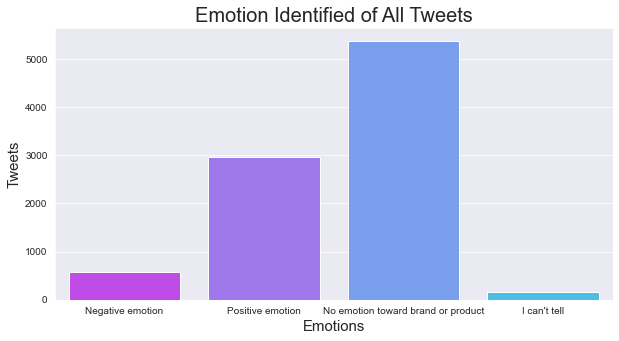

In [83]:
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
all_count_viz = sns.countplot(x=df['target'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 20)
all_count_viz.set_xlabel('Emotions',fontsize = 15)
all_count_viz.set_ylabel('Tweets',fontsize = 15)
plt.show()

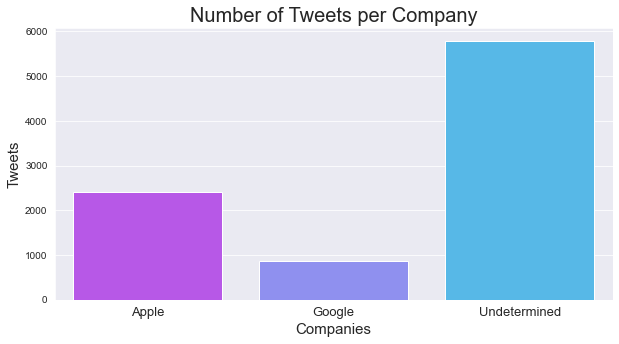

In [84]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Undetermined'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(x=df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

In [85]:
pos_text = df['tokenized'].loc[df['target'] == 'Positive emotion'].tolist() 
pos_text = ' '.join(pos_text).lower()

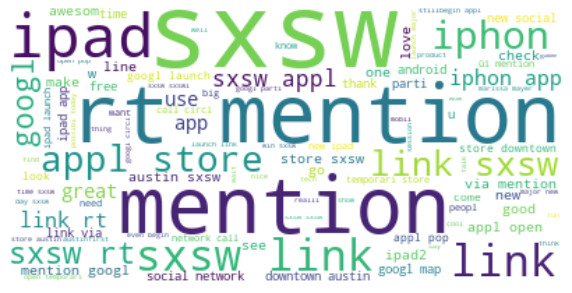

In [86]:
wc = WordCloud(max_font_size=75,
               background_color='white', 
               max_words=100).generate(pos_text)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [87]:
neg_text = df['tokenized'].loc[df['target'] == 'Negative emotion'].tolist() 
neg_text = ' '.join(neg_text).lower()

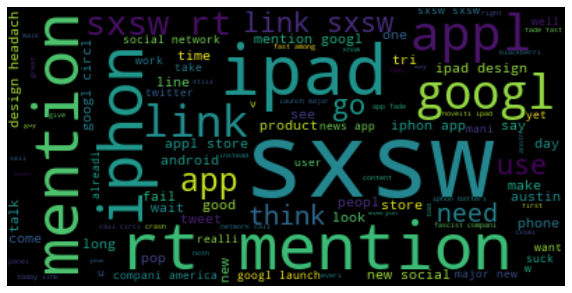

In [88]:
wc = WordCloud(max_font_size=75,
               max_words=100).generate(neg_text)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [89]:
neut_text = df['tokenized'].loc[df['target'] == 'No emotion toward brand or product'].tolist() 
neut_text = ' '.join(neut_text).lower()

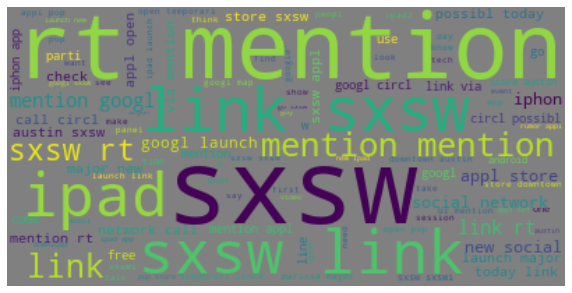

In [90]:
wc = WordCloud(max_font_size=75,
               max_words=100,
               background_color='grey').generate(neut_text)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [135]:
from nltk.tokenize import RegexpTokenizer
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
regex_token = RegexpTokenizer(r"\w+")

new_pos_text = df['text'].loc[df['target'] == 'Positive emotion'].tolist()
new_pos_text = ' '.join(new_pos_text).lower()
new_pos_text = regex_token.tokenize(new_pos_text)


# new_pos_text = [word for word in new_pos_text if word not in sw]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meaghanross/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [136]:
new_neg_text = df['text'].loc[df['target'] == 'Negative emotion'].tolist()
new_neg_text = ' '.join(new_neg_text).lower()
new_neg_text = regex_token.tokenize(new_neg_text)


In [137]:
new_neut_text = df['text'].loc[df['target'] == 'No emotion toward brand or product'].tolist()
new_neut_text = ' '.join(new_neut_text).lower()
new_neut_text = regex_token.tokenize(new_neut_text)

In [138]:
# new_neg_text = df['tokenized'].loc[df['target'] == 'Negative emotion'].tolist()
# new_neg_text= [i for item in new_neg_text for i in item.split()]

In [139]:
# new_neut_text = df['tokenized'].loc[df['target'] == 'No emotion toward brand or product'].tolist() 
# new_neut_text= [i for item in new_neut_text for i in item.split()]

In [140]:
unique_neg = set(new_neg_text)
unique_pos = set(new_pos_text)
unique_neut = set(new_neut_text)

In [141]:
only_pos= unique_pos.difference(unique_neut.union(unique_neg))

In [143]:
only_pos = ' '.join(only_pos)

In [145]:
only_neg= unique_neg.difference(unique_pos.union(unique_neut))

In [146]:
only_neg = ' '.join(only_neg)

In [149]:
only_neut= unique_neut.difference(unique_pos.union(unique_neg))

In [153]:
only_neut = ' '.join(only_neut)

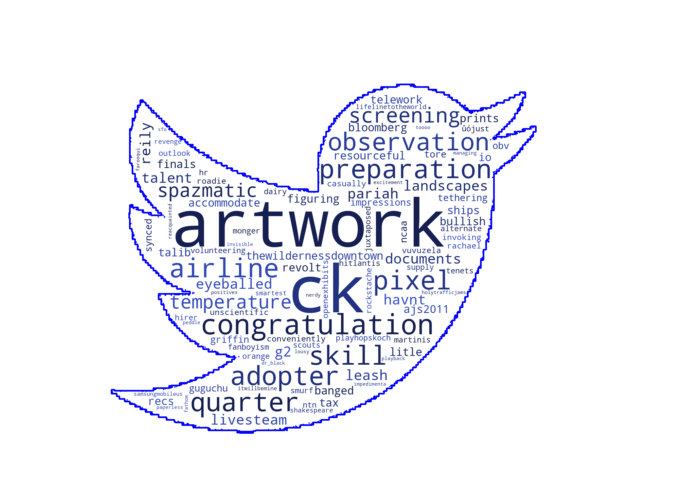

In [147]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random


def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 230
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=200, 
               mask=mask, 
               background_color = 'white',
               max_words=100,
               contour_width=5, 
               contour_color='blue',
               color_func = blue_color_func).generate(only_pos)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


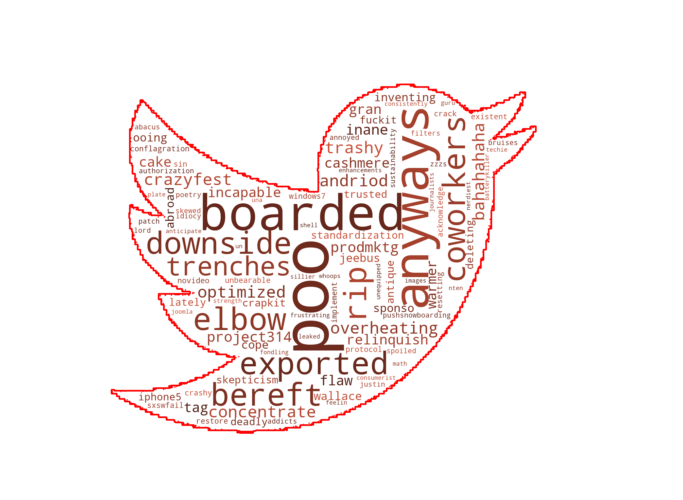

In [148]:
def red_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 10
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=200, 
               mask=mask, 
               background_color = 'white',
               max_words=100,
               contour_width=5, 
               contour_color='red',
               color_func=red_color_func).generate(only_neg)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

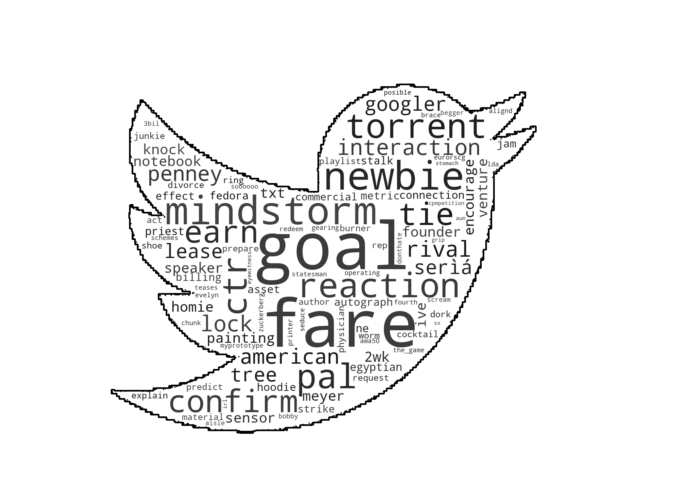

In [154]:
def grey_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 0
    s = int(100.0 * 0.0 / 255.0)
    l = int(100.0 * float(random_state.randint(20, 70)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=200, 
               mask=mask, 
               background_color = 'white',
               max_words=100,
               contour_width=5, 
               contour_color='black',
               color_func=grey_color_func).generate(only_neut)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()